# Prepare kinase-substrate dataset
>Combine pplus and large-scale

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

## Large scale dataset

In [2]:
# large_scale data
LS= pd.read_excel('raw/large_scale_final2.xlsx')

LS['gene_site'] = LS['S_position']

LS = LS[['Kinase','gene_site','substrate']]

LS_info = pd.read_csv('raw/LS_info.csv')

LS = LS.merge(LS_info).drop(columns = ['count'])

## PhosphoSitePlus dataset

In [3]:
KS = pd.read_csv('raw/Kinase_Substrate_Dataset_final.csv')

# only keep human kinase substrate pairs
KS = KS.query('KIN_ORGANISM=="human"')

# remove the substrate that does not have sty in the middle
KS = KS[KS.substrate.str[7].isin(['s','t','y'])].reset_index(drop=True)

KS['gene_site'] = KS.SUB_GENE.str.upper() + "_"+KS.SUB_MOD_RSD

KS = KS[['Kinase','gene_site','substrate','kinase_uniprot','kinase_paper']]

## Combine

In [4]:
KS['source'] = 'pplus'

LS['source'] = 'large_scale'

In [5]:
df = pd.concat([KS,LS]).reset_index(drop=True)

In [6]:
df

,Kinase,gene_site,substrate,kinase_uniprot,kinase_paper,source
0,DYRK2,GLI2_S385,AEGLRPAsPLGLTQE,Q92630,DYRK2,pplus
1,DYRK2,SIAH2_S68,GGGAGPVsPQHHELT,Q92630,DYRK2,pplus
2,DYRK2,CARHSP1_S41,LRGNVVPsPLPtRRt,Q92630,DYRK2,pplus
3,DYRK2,DCX_S306,GPMRRSKsPADSANG,Q92630,DYRK2,pplus
4,DYRK2,CDC25A_S283,PErsQEEsPPGSTKr,Q92630,DYRK2,pplus
...,...,...,...,...,...,...
216464,SPHK1,HERC2_S2928,AAVPFLAsDNEEEED,Q9NYA1,NaN,large_scale
216465,SPHK1,PARG_Y832,DALHFRRyLDQFVPE,Q9NYA1,NaN,large_scale
216466,SPHK1,G6PI_T109,ALRNRsNtPILVDGK,Q9NYA1,NaN,large_scale
216467,PRPK,TITIN_S20761,DAERKSWsTVTTECs,Q96S44,PRPK,large_scale


In [7]:
# kinase without mapping
df.loc[df.kinase_paper.isna()].Kinase.value_counts()

Kinase
LYNb            1694
ABL1[T315I]     1320
ABL1[E255K]     1274
RET[M918T]      1221
FGFR3[K650M]    1220
                ... 
GRP78              1
TAO3               1
PIK3CD             1
PIK3CB             1
G11                1
Name: count, Length: 80, dtype: int64

In [8]:
df.substrate.str[7].value_counts()

substrate
y    109225
s     74830
t     32414
Name: count, dtype: int64

In [9]:
df.source.value_counts()

source
large_scale    198248
pplus           18221
Name: count, dtype: int64

In [10]:
len(df)

216469

In [11]:
df['substrate'] = df['substrate'].\
str.replace('r', 'R').\
str.replace('k', 'K').\
str.replace('n', 'N').\
str.replace('d', 'D').\
str.replace('h', 'H').\
str.replace('c', 'C').\
str.replace('X', '_').\
str.replace('p', 'P').\
str.replace('a', 'A').\
str.replace('v', 'V').\
str.replace('g', 'G').\
str.replace('m', 'M').\
str.replace('l', 'L').\
str.replace('q', 'Q').\
str.replace('f', 'F')

Split phosphosite sequence to single amino acid

In [12]:
df

,Kinase,gene_site,substrate,kinase_uniprot,kinase_paper,source
0,DYRK2,GLI2_S385,AEGLRPAsPLGLTQE,Q92630,DYRK2,pplus
1,DYRK2,SIAH2_S68,GGGAGPVsPQHHELT,Q92630,DYRK2,pplus
2,DYRK2,CARHSP1_S41,LRGNVVPsPLPtRRt,Q92630,DYRK2,pplus
3,DYRK2,DCX_S306,GPMRRSKsPADSANG,Q92630,DYRK2,pplus
4,DYRK2,CDC25A_S283,PERsQEEsPPGSTKR,Q92630,DYRK2,pplus
...,...,...,...,...,...,...
216464,SPHK1,HERC2_S2928,AAVPFLAsDNEEEED,Q9NYA1,NaN,large_scale
216465,SPHK1,PARG_Y832,DALHFRRyLDQFVPE,Q9NYA1,NaN,large_scale
216466,SPHK1,G6PI_T109,ALRNRsNtPILVDGK,Q9NYA1,NaN,large_scale
216467,PRPK,TITIN_S20761,DAERKSWsTVTTECs,Q96S44,PRPK,large_scale


## Split site sequence to individual columns

In [13]:
# Split the 'SITE_+/-7_AA' column into individual letters
split_cols = df['substrate'].apply(list).apply(pd.Series).fillna('_')

# Rename the new columns from -7 to 7
split_cols.columns = range(-7, 8)

# Concatenate the original dataframe with the split columns
df = pd.concat([df, split_cols], axis=1)

In [14]:
df

,Kinase,gene_site,substrate,kinase_uniprot,kinase_paper,source,-7,-6,-5,-4,...,-2,-1,0,1,2,3,4,5,6,7
0,DYRK2,GLI2_S385,AEGLRPAsPLGLTQE,Q92630,DYRK2,pplus,A,E,G,L,...,P,A,s,P,L,G,L,T,Q,E
1,DYRK2,SIAH2_S68,GGGAGPVsPQHHELT,Q92630,DYRK2,pplus,G,G,G,A,...,P,V,s,P,Q,H,H,E,L,T
2,DYRK2,CARHSP1_S41,LRGNVVPsPLPtRRt,Q92630,DYRK2,pplus,L,R,G,N,...,V,P,s,P,L,P,t,R,R,t
3,DYRK2,DCX_S306,GPMRRSKsPADSANG,Q92630,DYRK2,pplus,G,P,M,R,...,S,K,s,P,A,D,S,A,N,G
4,DYRK2,CDC25A_S283,PERsQEEsPPGSTKR,Q92630,DYRK2,pplus,P,E,R,s,...,E,E,s,P,P,G,S,T,K,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216464,SPHK1,HERC2_S2928,AAVPFLAsDNEEEED,Q9NYA1,NaN,large_scale,A,A,V,P,...,L,A,s,D,N,E,E,E,E,D
216465,SPHK1,PARG_Y832,DALHFRRyLDQFVPE,Q9NYA1,NaN,large_scale,D,A,L,H,...,R,R,y,L,D,Q,F,V,P,E
216466,SPHK1,G6PI_T109,ALRNRsNtPILVDGK,Q9NYA1,NaN,large_scale,A,L,R,N,...,s,N,t,P,I,L,V,D,G,K
216467,PRPK,TITIN_S20761,DAERKSWsTVTTECs,Q96S44,PRPK,large_scale,D,A,E,R,...,S,W,s,T,V,T,T,E,C,s


## Add extra columns

In [15]:
df['kinase'] = df['kinase_paper'].fillna(df['Kinase'])

df['on_tree']=df['kinase_paper'].notna().astype(int)

## Save
>Uncheck below

In [16]:
df.columns = df.columns.astype(str) # Parquet can only save df with string column name
df.to_parquet('raw/df.parquet')

## Load data
> Need to convert the number in the columns to integer type

In [17]:
df = pd.read_parquet('raw/df.parquet')
#Convert the number in the column name into integer
df.columns = [int(col) if col.lstrip('-').isdigit() else col for col in df.columns]

## Visualize counts

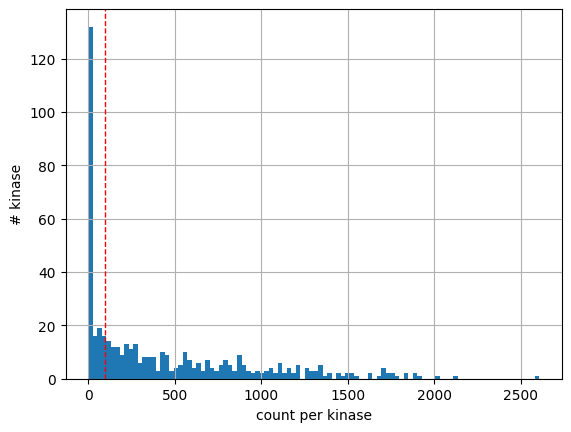

In [18]:
df.kinase.value_counts().hist(bins=100)
plt.axvline(x=100, color='r', linestyle='--', linewidth=1)
plt.xlabel('count per kinase')
plt.ylabel('# kinase');

In [19]:
cnt = df.kinase.value_counts().reset_index()

In [20]:
cnt.columns = ['kinase','count']

In [21]:
cnt

,kinase,count
0,SRC,2605
1,EPHA3,2120
2,FES,2013
3,NTRK3,1927
4,ALK,1889
...,...,...
488,CAMK1G,1
489,CAMK2D iso8,1
490,PHKA1,1
491,VPRBP,1
